In [1]:
%load_ext autoreload

In [2]:
%autoreload

import abc
from functools import partial
from typing import Any, Callable, Mapping, Optional, Sequence

import chex
import distrax
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.scipy.special as special
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import optax
from jax import random
from sklearn.datasets import make_moons
from tqdm.auto import tqdm

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any

# normalizing flow

In [3]:
class MLP(nn.Module):
    """A multi-layer perceptron (MLP)."""

    latent_sizes: Sequence[int]
    activation: Optional[Callable[[chex.Array], chex.Array]]
    skip_connections: bool = True
    activate_final: bool = False

    @nn.compact
    def __call__(self, inputs):
        for index, dim in enumerate(self.latent_sizes):
            next_inputs = nn.Dense(dim)(inputs)

            if index != len(self.latent_sizes) - 1 or self.activate_final:
                if self.activation is not None:
                    next_inputs = self.activation(next_inputs)

            if self.skip_connections and next_inputs.shape == inputs.shape:
                next_inputs = next_inputs + inputs

            inputs = next_inputs
        return inputs

In [4]:
class FlowConditioner(nn.Module):
    """Conditioner for the masked coupling normalizing flow."""

    event_shape: Sequence[int]
    latent_sizes: Sequence[int]
    activation: Callable[[chex.Array], chex.Array]
    num_bijector_params: int

    @nn.compact
    def __call__(self, inputs):
        inputs = jnp.reshape(inputs, (inputs.shape[0], -1))
        # inputs = jnp.reshape(inputs, (-1, *event_shape))
        inputs = MLP(self.latent_sizes, self.activation, activate_final=True)(inputs)
        # zero initialization for linear layer so flow starts as identity
        inputs = nn.Dense(
            np.prod(self.event_shape) * self.num_bijector_params,
            kernel_init=nn.initializers.zeros,
            bias_init=nn.initializers.zeros,
        )(inputs)
        inputs = jnp.reshape(
            inputs,
            inputs.shape[:-1] + tuple(self.event_shape) + (self.num_bijector_params,),
        )
        return inputs

In [118]:
@nn.jit
class NormalizingFlow(nn.Module):
    """Implements a masked coupling normalizing flow."""

    event_shape: Sequence[int]
    bijector_fn: Callable[[optax.Params], distrax.Bijector]
    conditioners: Sequence[FlowConditioner]

    def setup(self):
        ndim = np.prod(self.event_shape)

        # Alternating binary mask.
        mask = jnp.arange(0, ndim) % 2
        mask = jnp.reshape(mask, self.event_shape)
        mask = mask.astype(bool)

        layers = []
        for conditioner in self.conditioners:
            layer = distrax.MaskedCoupling(
                mask=mask, bijector=self.bijector_fn, conditioner=conditioner
            )
            layers.append(layer)

            # Flip the mask after each layer.
            mask = jnp.logical_not(mask)

        # Chain layers to create the flow.
        self.flow = distrax.Inverse(distrax.Chain(layers))
        self.base_dist = distrax.Independent(
            distrax.MultivariateNormalFullCovariance(
                loc=jnp.zeros(ndim),
                covariance_matrix=jnp.eye(ndim),
            )
        )
        self.trans_dist = distrax.Transformed(self.base_dist, self.flow)

        self.mean = self.variable("stats", "mean", jnp.zeros, (ndim,))
        self.std = self.variable("stats", "std", jnp.ones, (ndim,))

        return self.flow, self.base_dist, self.trans_dist

    def __call__(self, x: Array):
        return self.forward(x)

    def forward(self, x: Array):
        return self.flow.forward(x)

    def inverse(self, x: Array):
        return self.flow.inverse(x)

    def sample_base(self, key: PRNGKey, n: int):
        return self.base_dist.sample(seed=key, sample_shape=n)

    def sample_transformed(self, key: PRNGKey, n: int):
        z = self.sample_base(key, n)
        return self.forward(z)

    def sample_and_log_prob_base(self, key: PRNGKey, n: int):
        return self.base_dist.sample_and_log_prob(seed=key, sample_shape=n)

    def sample_and_log_prob_transformed(self, key: PRNGKey, n: int):
        z = self.sample_transformed(key, n)
        return z, self.log_prob_transformed(z)

    def forward_and_log_det(self, x: Array):
        """Encodes inputs as latent vectors."""
        return self.flow.forward_and_log_det(x)

    def inverse_and_log_det(self, x: Array):
        """Applies the inverse flow to the latents."""
        return self.flow.inverse_and_log_det(x)

    def log_prob_base(self, x: Array):
        return self.base_dist.log_prob(x)

    def log_prob_transformed(self, x: Array):
        return self.trans_dist.log_prob(x)

    def get_base_dist(self):
        return self.base_dist

    def get_trans_dist(self):
        return self.trans_dist

    def get_flow(self):
        return self.flow

In [119]:
def create_flow(
    init_shape,
    spline_range_min=0.0,
    spline_range_max=1.0,
    spline_bins=50,
    activation="relu",
    num_flow_layers=8,
    latent_sizes=[500, 500],
):
    """Builds the normalizing flow model."""
    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
    def bijector_fn(params):
        return distrax.RationalQuadraticSpline(
            params,
            range_min=spline_range_min,
            range_max=spline_range_max,
        )

    num_bijector_params = 3 * spline_bins + 1

    # Construct activation.
    activation = getattr(jax.nn, activation, None)
    conditioners = []
    for _ in range(num_flow_layers):
        conditioner = FlowConditioner(
            event_shape=tuple((init_shape[-1],)),
            latent_sizes=latent_sizes,
            activation=activation,
            num_bijector_params=num_bijector_params,
        )
        conditioners.append(conditioner)

    return NormalizingFlow(
        event_shape=init_shape[-1],
        bijector_fn=bijector_fn,
        conditioners=conditioners,
    )

# make target density

In [138]:
@partial(jax.jit, static_argnums=(0, 1, 2, 4))
def mesh_eval(func, x_limits, y_limits, params=None, num_ticks=101):
    # Evaluate func on a 2D grid defined by x_limits and y_limits.
    x = np.linspace(*x_limits, num=num_ticks)
    y = np.linspace(*y_limits, num=num_ticks)
    X, Y = np.meshgrid(x, y)
    xy_vec = np.stack([X.ravel(), Y.ravel()]).T
    try:
        if params is not None:
            zs = jax.vmap(func, in_axes=(0, None))(xy_vec, params)
        else:
            zs = jax.vmap(func)(xy_vec)
    except:
        if params is not None:
            zs = func(xy_vec, params)
        else:
            zs = func(xy_vec)
    return X, Y, zs.reshape(X.shape)

In [136]:
class DualMoonDistribution(distrax.Distribution):
    def __init__(self):
        super(DualMoonDistribution, self).__init__()
        self.event_shape = 2

    def event_shape(self):
        return self.event_shape

    def _sample_n(self, key, sample_shape=()):
        # it is enough to return an arbitrary sample with correct shape
        return jnp.zeros((sample_shape, self.event_shape))

    def log_prob(self, x):
        term1 = 0.5 * ((jnp.linalg.norm(x, axis=-1) - 2) / 0.4) ** 2
        term2 = -0.5 * ((x[..., :1] + jnp.array([-2.0, 2.0])) / 0.6)
        pe = term1 - special.logsumexp(term2, axis=-1)
        return -pe

In [137]:
dualmoon = DualMoonDistribution()

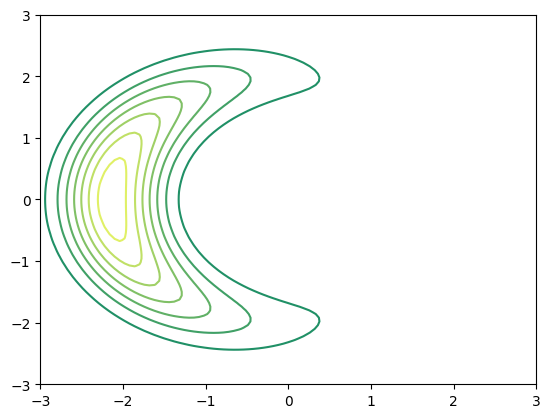

In [139]:
x, y, z = mesh_eval(dualmoon.log_prob, (-3, 3), (-3, 3))
plt.contour(x, y, jnp.exp(z), cmap="summer")

# make flow

In [226]:
flow = create_flow(
    [1, 2],
    spline_bins=50,
    num_flow_layers=8,
    latent_sizes=[250, 250],
    activation="relu",
    spline_range_min=-3.0,
    spline_range_max=3.0,
)
key = random.PRNGKey(1)
params = flow.init(
    key,
    random.normal(key, [1, 2]),
)

In [234]:
def loss(params, key, n_samples=5):
    q, ld = flow.apply(
        params, key, n_samples, method=flow.sample_and_log_prob_transformed
    )
    l = dualmoon.log_prob(q) - ld
    return -l.mean()


lvg = jax.jit(jax.value_and_grad(loss))


def train_step(params, key, opt_state):
    l, grads = lvg(params, key)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, l

In [228]:
opt = optax.adam(1e-3)
opt_state = opt.init(params)

In [229]:
losses = []

In [230]:
for i in (pbar := tqdm(range(1_000))):
    key, subkey = jax.random.split(key)
    params, opt_state, l = train_step(params, key, opt_state)
    losses.append(l)
    if i % 10 == 0:
        pbar.set_description(f"loss: {l:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

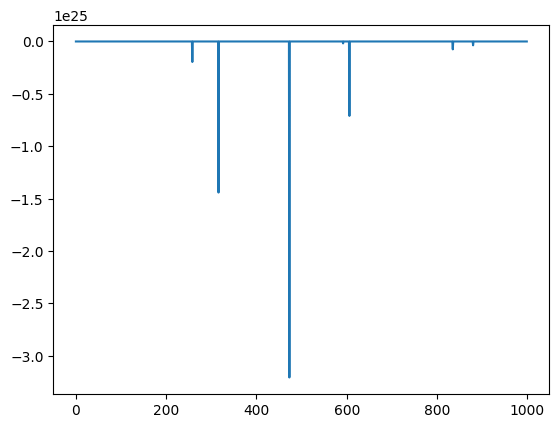

In [231]:
plt.plot(losses)

(-5.0, 5.0)

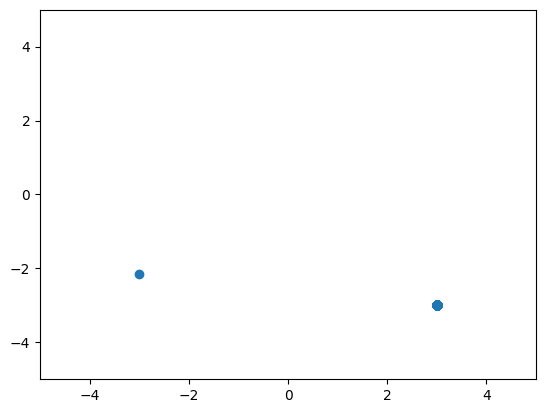

In [232]:
x = flow.apply(params, key, 1000, method=flow.sample_transformed)
plt.scatter(x[:, 0], x[:, 1])
plt.xlim(-5, 5)
plt.ylim(-5, 5)

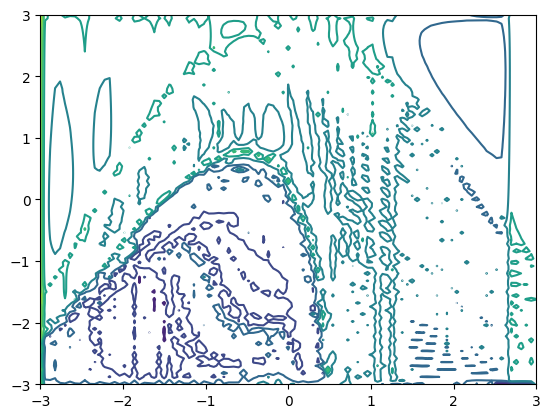

In [233]:
plt.contour(
    *mesh_eval(
        lambda x: flow.apply(params, x, method=flow.log_prob_transformed),
        (-3, 3),
        (-3, 3),
    )
)

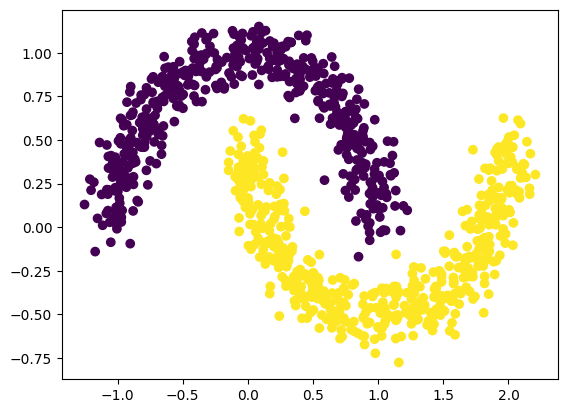

In [97]:
moons, cats = make_moons(1000, noise=0.1)
plt.scatter(moons[:, 0], moons[:, 1], c=cats)

In [194]:
k1, k2 = random.split(key)
batch_size = 512
x2_dist = distrax.Normal(loc=0.0, scale=3.0)
x2_samples = x2_dist.sample(seed=k1, sample_shape=batch_size)
x1 = distrax.Normal(
    loc=0.1 * jnp.square(x2_samples), scale=jnp.ones(batch_size, dtype=jnp.float32)
)
x1_samples = x1.sample(seed=k2)
x_samples = jnp.stack([x1_samples, x2_samples], axis=1)

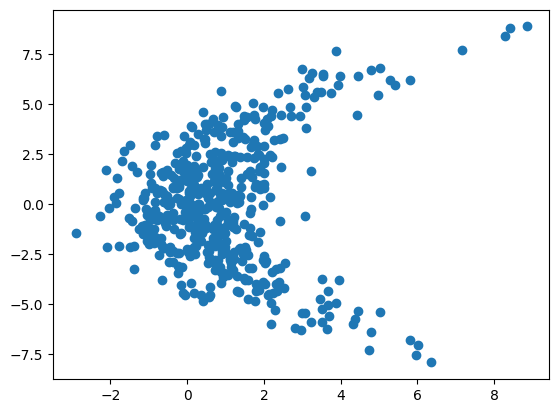

In [195]:
plt.scatter(x_samples[:, 0], x_samples[:, 1])

In [215]:
flow = create_flow(
    [1, 2],
    spline_bins=100,
    num_flow_layers=16,
    latent_sizes=[100, 100, 100],
    activation="relu",
    spline_range_min=-3.0,
    spline_range_max=3.0,
)
key = random.PRNGKey(0)
params = flow.init(
    key,
    random.normal(
        key,
        [1, 2],
    ),
)

In [216]:
def loss(params, samples):
    l = flow.apply(params, samples, method=flow.log_prob_transformed)
    return -l.mean()


@jax.jit
def train_step(params, opt_state):
    l, grads = jax.value_and_grad(loss)(params, x_samples)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, l


opt = optax.sgd(1e-4, momentum=0.9)
opt_state = opt.init(params)

In [217]:
losses = []

In [218]:
for i in (pbar := tqdm(range(15_000))):
    params, opt_state, l = train_step(params, opt_state)
    losses.append(l)
    if i % 100 == 0:
        pbar.set_description(f"loss: {l:.2f}")

  0%|          | 0/15000 [00:00<?, ?it/s]

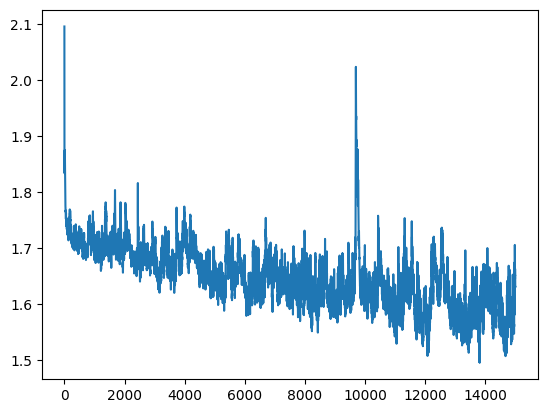

In [219]:
plt.plot(np.log(losses))

(-5.0, 5.0)

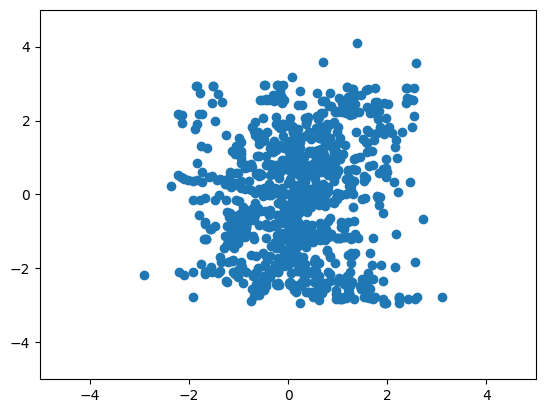

In [220]:
samples = flow.apply(params, key, 1000, method=flow.sample_transformed)
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlim(-5, 5)
plt.ylim(-5, 5)

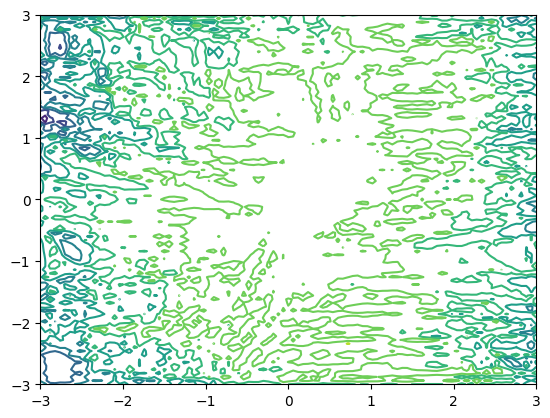

In [221]:
plt.contour(
    *mesh_eval(
        lambda x: flow.apply(params, x, method=flow.log_prob_transformed),
        (-3, 3),
        (-3, 3),
    )
)